In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout,Bidirectional,GRU,SimpleRNN
from tensorflow.keras import regularizers
import re
import os
import json
import nltk
import gzip
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer(language='english')
NUM_Classes = 5
EPOCHS_NUM = 5

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
english_stops = set(stopwords.words('english'))

In [4]:
!wget wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=124bgAX2yrB9z8an1tMj7SwQ3nRekuzZs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=124bgAX2yrB9z8an1tMj7SwQ3nRekuzZs" -O Sports_and_Outdoors_5.json.gz && rm -rf /tmp/cookies.txt

--2023-06-13 05:33:50--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-06-13 05:33:50--  https://docs.google.com/uc?export=download&confirm=t&id=124bgAX2yrB9z8an1tMj7SwQ3nRekuzZs
Resolving docs.google.com (docs.google.com)... 209.85.146.139, 209.85.146.100, 209.85.146.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.146.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ir3uotmo76kh1p94j7lq32odh043ifs1/1686634425000/01865608280713457520/*/124bgAX2yrB9z8an1tMj7SwQ3nRekuzZs?e=download&uuid=9a36e8a3-1bc4-4e30-9c1e-9fc68417e171 [following]
--2023-06-13 05:33:50--  https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ir3uotmo76kh1p94j7lq32odh043ifs1/1686634425000/01865608280713457520/*/124bgAX2yrB9z8an1tMj7SwQ3nRekuzZs?e=download&uuid=

In [5]:
import gensim.downloader as api
wv_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [6]:
def read_data(n=1000):
    data_json = gzip.open('Sports_and_Outdoors_5.json.gz', 'rt', encoding='UTF-8')


    data = {'review':[], 'overall':[]}
    for i in range(n):
        try:
            d = json.loads(data_json.readline())
            # print(d)
            data['review'].append(d['reviewText'])
            data['overall'].append(int(d['overall']))
        except:
            pass
            
    df = pd.DataFrame(data) 


    x_data = df['review']
    y_data = df['overall']

    x_data = x_data.replace({'<.*?>': ''}, regex=True)  # remove html tag
    x_data = x_data.replace({'[^0-9A-Za-z #+_]': ' '}, regex=True)# remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])
    x_data = x_data.apply(lambda review: [snow_stemmer.stem(w) for w in review]) # stem

    return x_data, y_data

In [7]:
def one_hot(y):
    ret = np.zeros((y.size, y.max()))

    ret[np.arange(y.size), y-1] = 1.0
    return ret

In [8]:
def one_hot_matrix(integer_array, num_classes):
    num_examples = len(integer_array)
    one_hot_matrix = np.zeros((num_examples, num_classes))
    
    for i, integer_value in enumerate(integer_array):
        one_hot_matrix[i, integer_value-1] = 1
    
    return one_hot_matrix


In [9]:
def global_length(x_train): ## mean of lenghts 
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [10]:
def generate_dtset(x,y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.01,shuffle=True)

  # y_train = one_hot_matrix(y_train,NUM_Classes)
  # y_test = one_hot_matrix(y_test,NUM_Classes)
  print(type(y))
  y_train = one_hot(y_train)
  return x_train, x_test, y_train, y_test

In [53]:
def generate_dtset_135_24(x,y):
  x_train, x_test, y_train, y_test =[],[],[],[]
  for i,label in enumerate(y):
    if label==3 or label==1 or label==5: # 135 -> train
      x_train.append(x[i])
      y_train.append(label)

    else:# 24 -> test
        x_test.append(x[i])
        y_test.append(label) 
  y_train = one_hot(np.array(y_train))
  return np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)


In [11]:
X, Y = read_data(2400000)
#X, Y = read_data(10)

In [21]:
X.to_numpy().shape

(2399143,)

In [22]:
X.to_numpy()[0]

['what', 'spectacular', 'tutu', 'veri', 'slim']

In [55]:
# if 135 
x_train, x_test, y_train, y_test = generate_dtset_135_24(X.to_numpy(),Y.to_numpy())

<ipython-input-53-b954df6ccf2a>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)


In [12]:
# x_train, x_test, y_train, y_test = generate_dtset(X,Y)

<class 'pandas.core.series.Series'>


In [56]:
(y_train[:20])

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [34]:
# initiate tokenizer and fit in x_train data
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train)

In [35]:
#tokenize x_train + x_test
x_train_encd = tokenizer.texts_to_sequences(x_train)
x_test_encd = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1

In [36]:
vocab_size

138822

In [37]:
# pad x_train + x_test

maxlen=global_length(x_train_encd)
x_train_encd = pad_sequences(x_train_encd,maxlen)
x_test_encd = pad_sequences(x_test_encd,maxlen)

In [38]:
x_train_encd.shape

(1894306, 26)

In [39]:
wv_model['sara'].shape

(100,)

In [40]:
def get_w2v_embd(wv_model,tokenizer,embed_dim=100):
  vocab_size = len(tokenizer.word_index) + 1
  e = np.zeros((vocab_size,embed_dim))
  for w,i in tokenizer.word_index.items():
    try:
      v_e = wv_model[w]
    except:
        pass

    e[i]=v_e     

  return e

In [41]:
matrix_W2V=get_w2v_embd(wv_model,tokenizer)

In [42]:
(matrix_W2V).shape

(138822, 100)

In [57]:
# model 
# EMBED_DIM = 32
EMBED_DIM = 128
#LSTM_OUT = 64
LSTM_OUT = 128
dropout_rate = 0.2
learning_rate=0.001
#learning_rate=0.0001
use_w2v=False
from keras.initializers import Constant
model =Sequential()

if use_w2v:
  # model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen,  weights=[matrix_W2V], trainable=True))
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen,  embeddings_initializer=Constant(matrix_W2V)))

else:
  model.add(Embedding(input_dim=vocab_size,output_dim=EMBED_DIM,input_length=maxlen))
  
#model.add(LSTM(units=LSTM_OUT,kernel_regularizer=regularizers.l2(0.01)))
# model.add(LSTM(units=LSTM_OUT))
# model.add(tf.keras.layers.Bidirectional(LSTM(LSTM_OUT, dropout=dropout_rate)))
# model.add(GRU(units=LSTM_OUT))
# model.add(SimpleRNN(units=LSTM_OUT))

model.add(LSTM(units=LSTM_OUT, return_sequences=True))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.BatchNormalization())

model.add(LSTM(units=LSTM_OUT, return_sequences=True))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.BatchNormalization())

model.add(LSTM(units=LSTM_OUT, return_sequences=False))
model.add(Dropout(rate=dropout_rate))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(5, activation='softmax'))
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 128)           17769216  
                                                                 
 lstm_3 (LSTM)               (None, 26, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 26, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 26, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 26, 128)           0         
                                                      

In [59]:
EPOCHS_NUM = 8
history = model.fit(x_train_encd, y_train, batch_size=256, epochs=EPOCHS_NUM, validation_split=0.1)
 

Epoch 1/8
6660/6660 [==============================] - 162s 23ms/step - loss: 0.3042 - accuracy: 0.8905 - val_loss: 0.2491 - val_accuracy: 0.9092
Epoch 2/8
6660/6660 [==============================] - 107s 16ms/step - loss: 0.2601 - accuracy: 0.9052 - val_loss: 0.2389 - val_accuracy: 0.9128
Epoch 3/8
6660/6660 [==============================] - 102s 15ms/step - loss: 0.2470 - accuracy: 0.9101 - val_loss: 0.2352 - val_accuracy: 0.9139
Epoch 4/8
6660/6660 [==============================] - 101s 15ms/step - loss: 0.2370 - accuracy: 0.9140 - val_loss: 0.2367 - val_accuracy: 0.9146
Epoch 5/8
6660/6660 [==============================] - 105s 16ms/step - loss: 0.2277 - accuracy: 0.9178 - val_loss: 0.2310 - val_accuracy: 0.9156
Epoch 6/8
6660/6660 [==============================] - 103s 15ms/step - loss: 0.2197 - accuracy: 0.9208 - val_loss: 0.2366 - val_accuracy: 0.9157
Epoch 7/8
6660/6660 [==============================] - 105s 16ms/step - loss: 0.2125 - accuracy: 0.9238 - val_loss: 0.2353 -

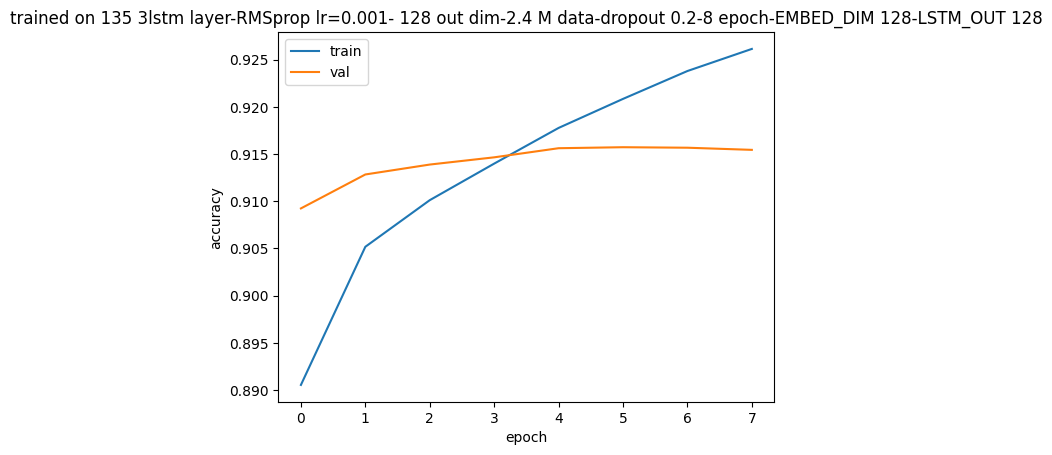

In [66]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
title = 'trained on 135 3lstm layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128'
plt.title(title)
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(title+'.png')
plt.show()

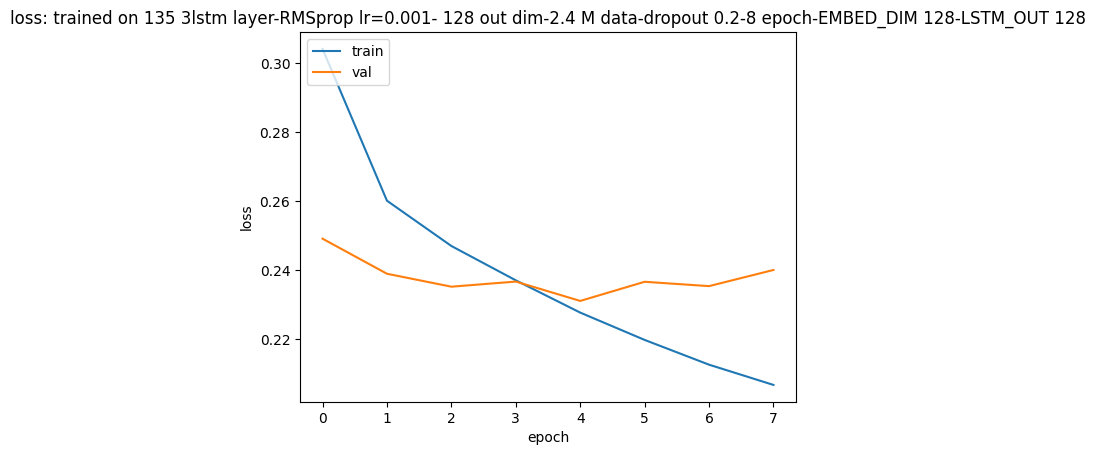

In [65]:
from matplotlib import pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
title = 'loss: trained on 135 3lstm layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128'
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(title+'.png')
plt.show()

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
# test_loss, test_accuracy = model.evaluate(x_test_encd,y_test,batch_size=256)

In [ ]:
# test_loss, test_accuracy = model.evaluate(x_test_encd,y_test,batch_size=32)

In [62]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test_encd)

y_pred_ = []
for i in range(y_pred.shape[0]):
  y_pred_.append(np.argmax(y_pred[i])+1)

accuracy_score(y_pred_, y_test)

15777/15777 [==============================] - 62s 4ms/step


0.0

In [78]:
len(y_pred_)

504837

In [81]:
for data in [13,100,567,239,600]:
        print(f'ground label: {y_test[data]}, Predicted label: {y_pred_[data]}')

ground label: 4, Predicted label: 5
ground label: 4, Predicted label: 5
ground label: 2, Predicted label: 3
ground label: 4, Predicted label: 5
ground label: 2, Predicted label: 5


In [ ]:
# print('test_loss: ',test_loss)
# print('test_accuracy: ',test_accuracy)

In [ ]:
# del model
# import gc
# gc.collect()

20700

In [52]:
#1 lstm layer-adam lr=0.0001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128  (base)
# 14995/14995 [==============================] - 63s 4ms/step - loss: 1.5980 - accuracy: 0.5703


#1 lstm layer-adam lr=0.0001- 64 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128
#14995/14995 [==============================] - 64s 4ms/step - loss: 1.0228 - accuracy: 0.6770

## ///////////////////////////////////////////

# 1 Bidirectional layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128    ?????
#  loss: 1.6450 - accuracy: 0.7479576525508503


# 1 lstm layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
#   0.7447065688562854


# 1 GRU layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.7494581527175725 

# 1 SimpleRNN layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.711403801267089


#2 LSTM layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128'
#0.7489163054351451

# 3 LSTM layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.7512087362454152     *******

# 2 lstm+1 gru layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.7476658886295432

# 4 LSTM layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.7510003334444815

# W2V 3lstm layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.7496248749583194

#trained on 135 3lstm layer-RMSprop lr=0.001- 128 out dim-2.4 M data-dropout 0.2-8 epoch-EMBED_DIM 128-LSTM_OUT 128
# 0.0

